In [ ]:
import sctoolbox
from sctoolbox.utilities import bgcolor

# Velocity / Pseudotime Analysis

This notebook can be used for velocity and pseudotime analysis of scRNA and scATAC data mostrly using the scvelo package.  
Most analysis steps are directly taken from the scvelo [documentation](https://scvelo.readthedocs.io/en/stable/VelocityBasics.html).

### Velocity Analysis
RNA velocity describes the rate of gene expression change for an individual gene at a given time point based on the ratio of its spliced and unspliced messenger RNA (mRNA).
A significantly higher unspliced mRNA count for a specific gene indicates that the future cell state would likely show a expression increase. On the other hand, a significantly higher spliced mRNA count for a specific gene indicates that the future cell state would likely show a depletion of expression.
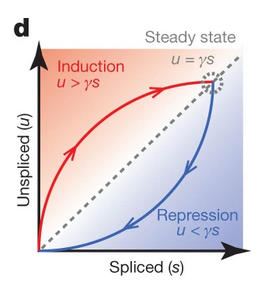
<span style="color:lightgrey">Image source: La Manno, G., Soldatov, R., Zeisel, A. et al. RNA velocity of single cells. Nature 560, 494–498 (2018). https://doi.org/10.1038/s41586-018-0414-6</span>.

### Pseudotime Analysis
For peusotime ordering (or trajectory interference) cells are ordered along a continuous path based on their difference in gene expression. This differs from the velocity analysis which uses the rate of unspliced and spliced mRNAs.  
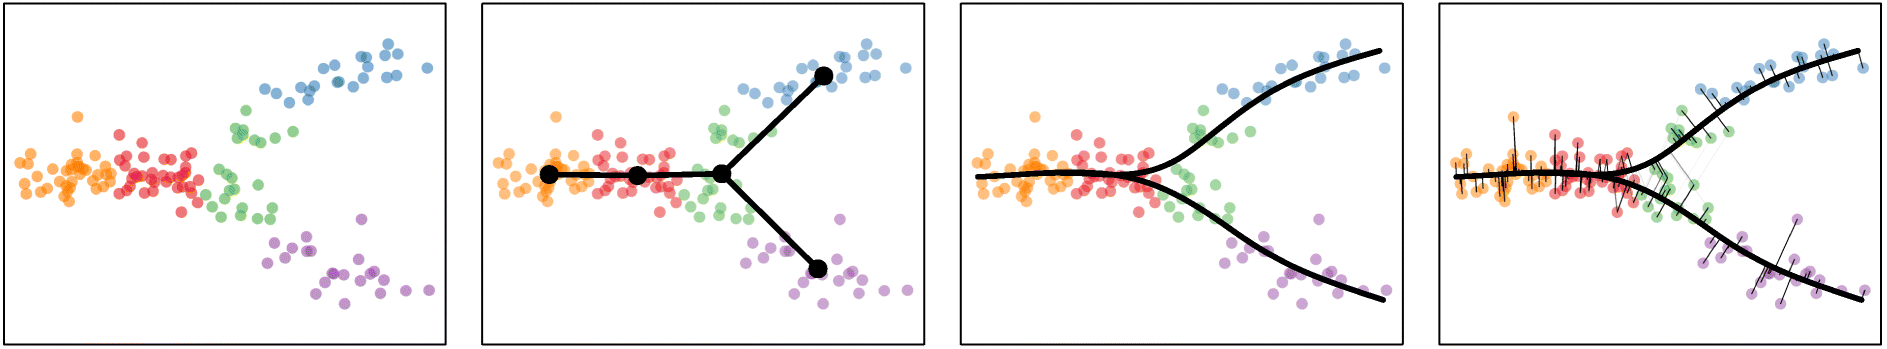
<span style="color:lightgrey">Image source: https://en.wikipedia.org/wiki/Trajectory_inference</span>.

## Setup

In [2]:
from sctoolbox import settings
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import sctoolbox.utilities as utils

Unable to determine R home: [Errno 2] No such file or directory: 'R'


## Input 

In [9]:
# In/output paths
settings.adata_input_dir = "../adatas/"
settings.adata_output_dir = "../adatas/"
figdir = '../figures/velocity/'
settings.log_file: "velocity_analysis_log.txt"

# Input filename
last_notebook_adata = "anndata_4.h5ad"

# Path to vdata object typically stored in starsolo/quant/velocyto/raw/vdata.h5ad
vdata_path = ""
# Column containing final clustering
clustering = "clusters" # clustering
# Embedding umap/tsne
embedding = "umap"
# Number of pcs
n_pcs = 10

# Genes of interest
goi = []

# Number of threads
threads = 4

In [4]:
scv.settings.figdir = figdir
sc.settings.figdir = figdir

## Load anndata

In [ ]:
adata = utils.load_h5ad("last_notebook_adata")
display(adata)

In [5]:
# temp
adata = scv.datasets.pancreas()

## Check for spliced/unspliced/ambiguous layer

In [6]:
if not set(adata.layers.keys()).issubset({"spliced", "unspliced", "ambiguous"}):
    # load vdata
    vdata = sc.load_h5ad(filename=vdata_path)
    
    # Check for obs index overlap
    if not set(adata.obs.index).issubset(set(vdata.obs.index)):
        raise ValueError("adata.obs.index does not overlap with vdata.obs.index. Please check the .obs indices.")
    
    # Merge adata vs vdata
    scv.utils.merge(adata, vadata, copy=False)

## Preprocessing

In [7]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata, n_pcs=n_pcs)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors


/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Calculate velocity

In [10]:
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata, n_jobs=threads)
scv.tl.velocity_confidence(adata)

computing velocities


/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:25) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 4/12 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:32) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


## Visualization

#### Proportion

saving figure to file ../figures/velocity/scvelo_proportions_velocity_proportion.pdf


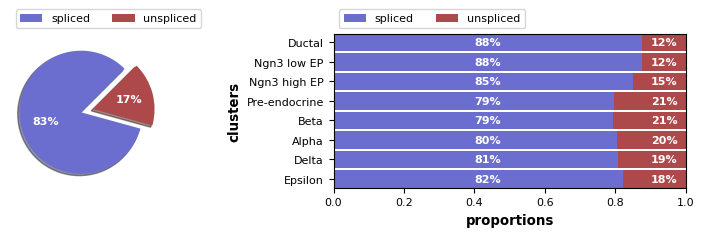

In [11]:
scv.pl.proportions(adata, groupby=clustering, save="velocity_proportion.pdf")

#### Embedding

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


saving figure to file ../figures/velocity/scvelo_velocity_embeding_stream.pdf


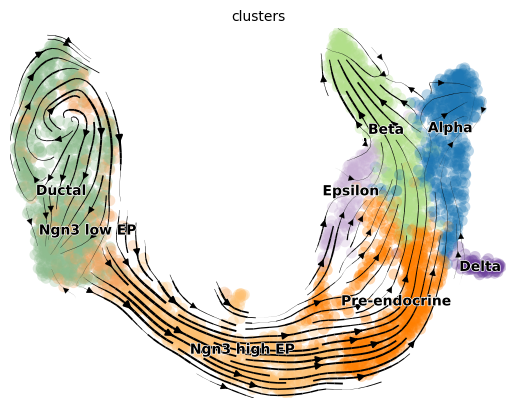

In [12]:
scv.pl.velocity_embedding_stream(adata, basis=embedding, color=clustering, save="velocity_embeding_stream.pdf")

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


saving figure to file ../figures/velocity/scvelo_velocity_embeding.pdf


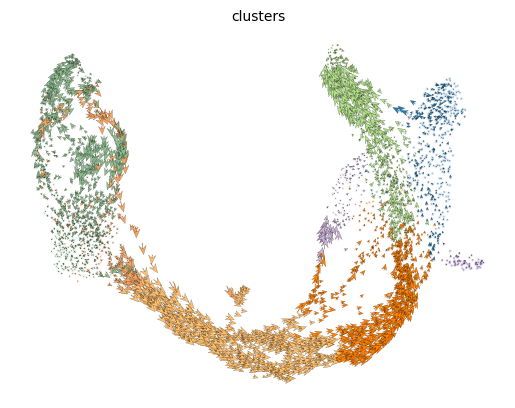

In [13]:
scv.pl.velocity_embedding(adata, color=clustering, arrow_length=3, arrow_size=3,  save="velocity_embeding.pdf")

#### Velocity length and confidence

The speed or rate of differentiation is given by the length of the velocity vector.  
The coherence of the vector field (i.e., how a velocity vector correlates with its neighboring velocities) provides a measure of confidence.

saving figure to file ../figures/velocity/scvelo_velocity_confidence.pdf


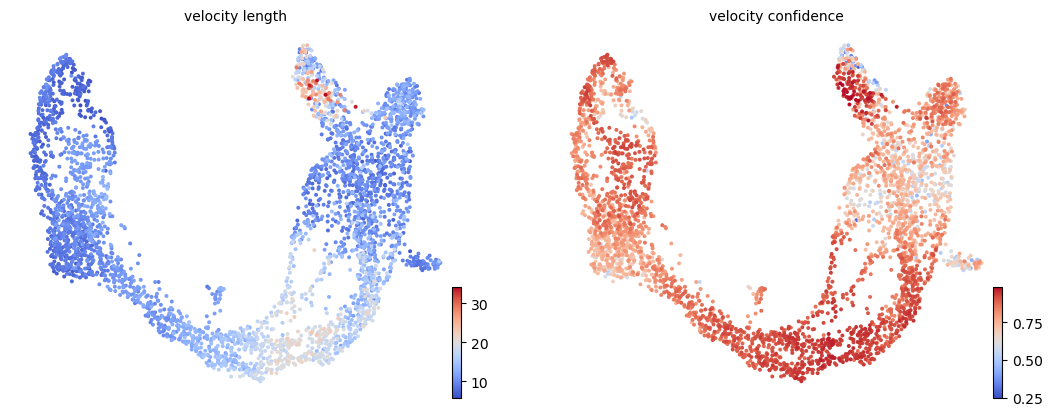

In [14]:
keys = ['velocity_length', 'velocity_confidence']
scv.pl.scatter(adata, c=keys, cmap='coolwarm', save="velocity_confidence.pdf")

In [15]:
df = adata.obs.groupby(clustering)[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

#### Velocity graph

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


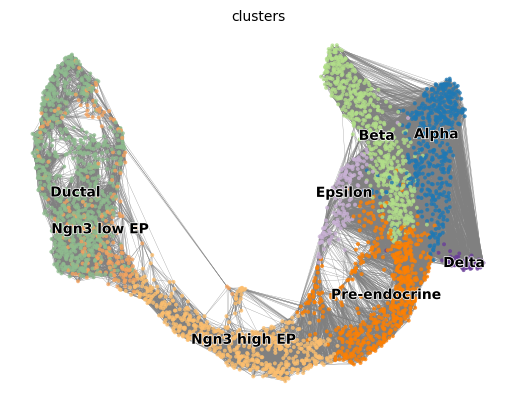

In [16]:
scv.pl.velocity_graph(adata, threshold=.1, color=clustering)

## Pseudotime - scVelo

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


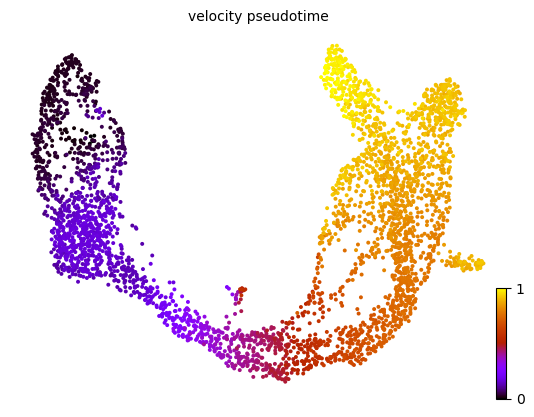

In [17]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

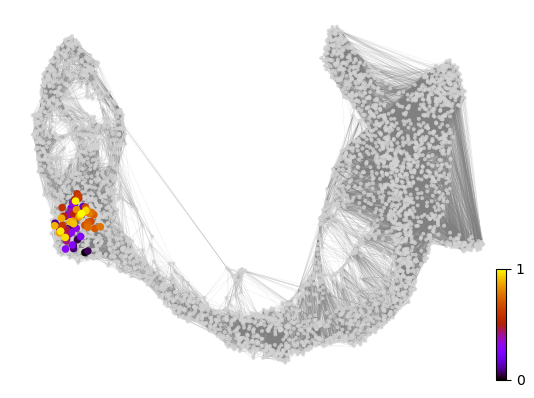

In [18]:
# TODO how to find starting cell??
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=2735)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

### PAGA

In [19]:
# this is needed due to a current bug - bugfix is coming soon.
#adata.uns['neighbors']['distances'] = adata.obsp['distances']
#adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='clusters')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


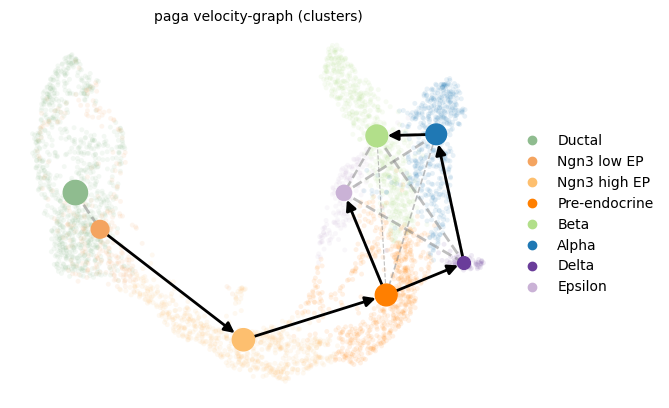

In [20]:
scv.pl.paga(adata, basis=embedding, color=clustering, size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5)

## Pseudotime - scanpy

In [21]:
adata_copy = adata.copy()

#### Preprocessing

In [22]:
sc.tl.diffmap(adata_copy)
sc.pp.neighbors(adata_copy, n_neighbors=10, use_rep='X_diffmap')

#### Trajectory Graph

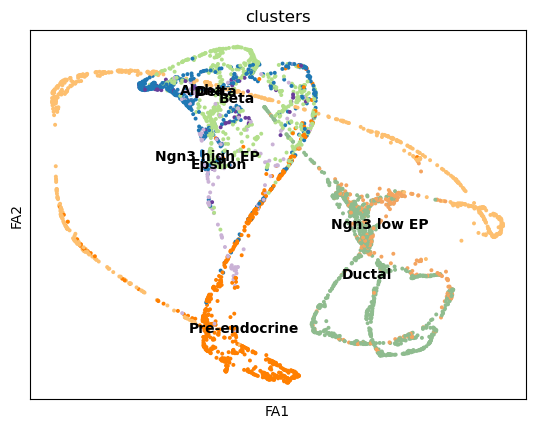

In [23]:
sc.tl.draw_graph(adata_copy)
sc.pl.draw_graph(adata_copy, color=clustering, legend_loc='on data')

#### PAGA

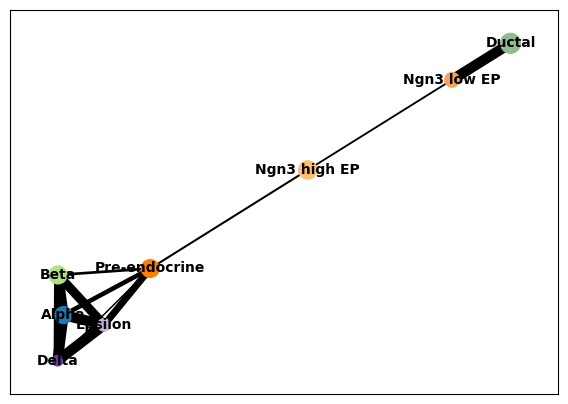

In [24]:
sc.tl.paga(adata_copy, groups=clustering)
sc.pl.paga(adata_copy, color=clustering)

#### Trajectory Graph with PAGA base

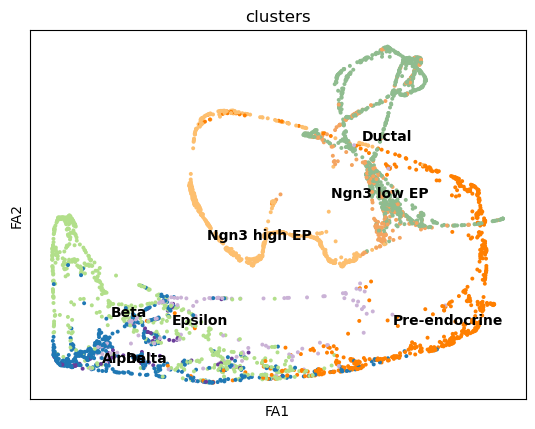

In [25]:
sc.tl.draw_graph(adata_copy, init_pos='paga')
sc.pl.draw_graph(adata_copy, color=clustering, legend_loc='on data')

#### Pseudotime on trajectory graph

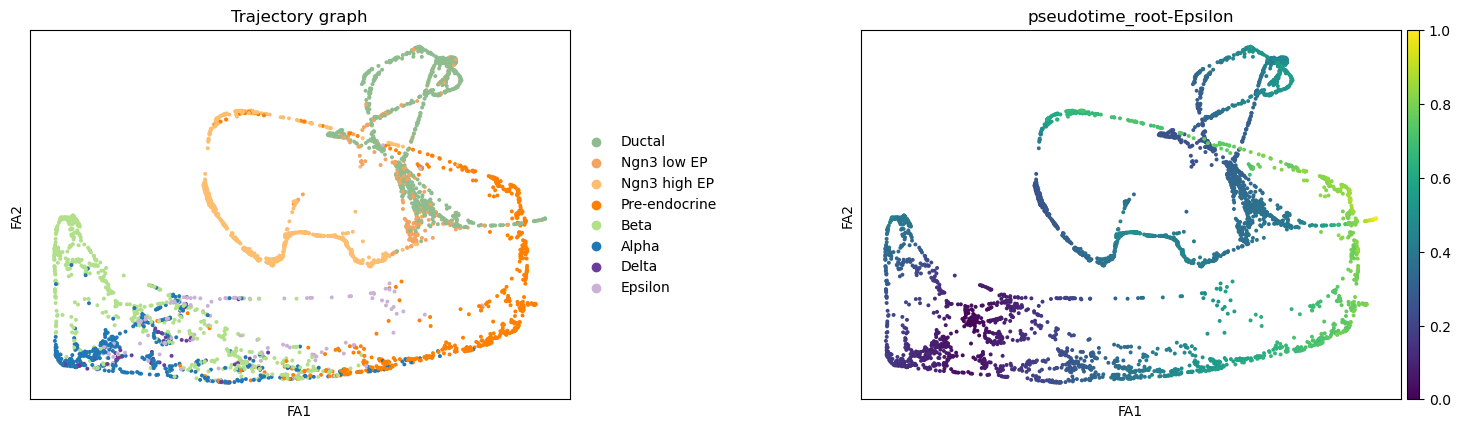

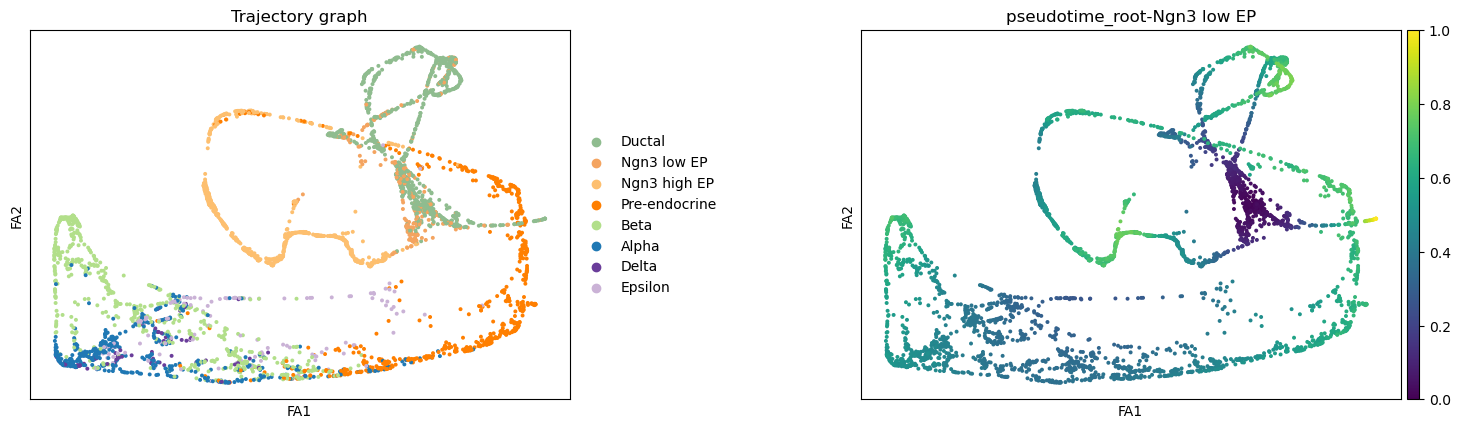

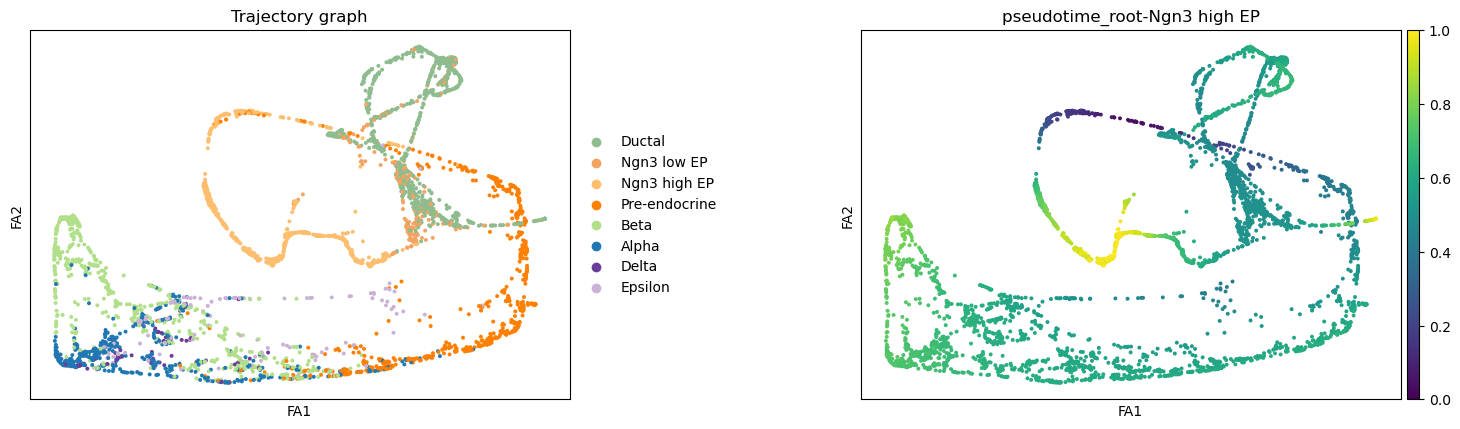

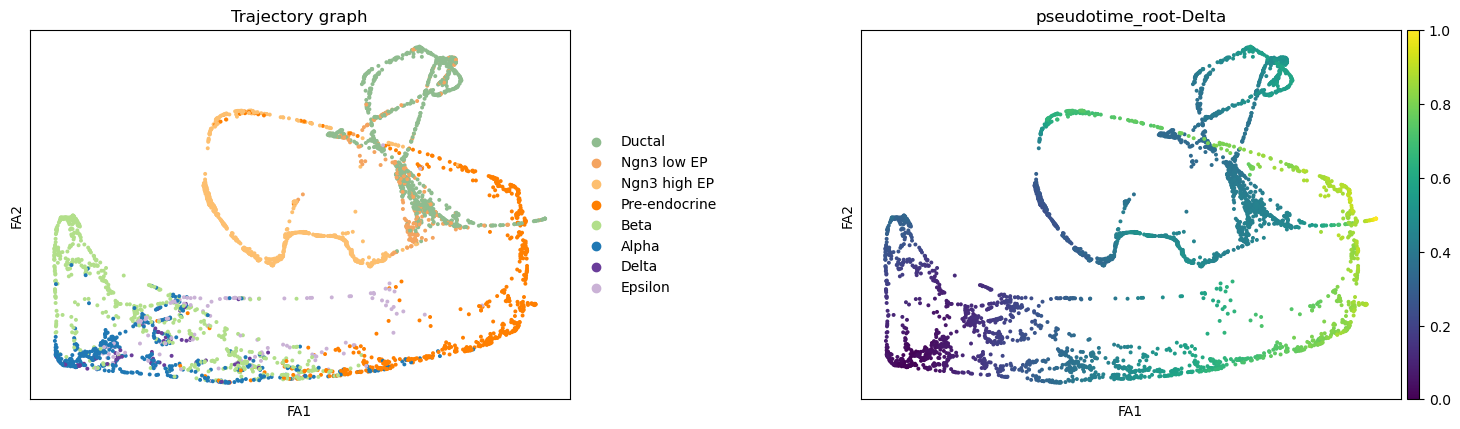

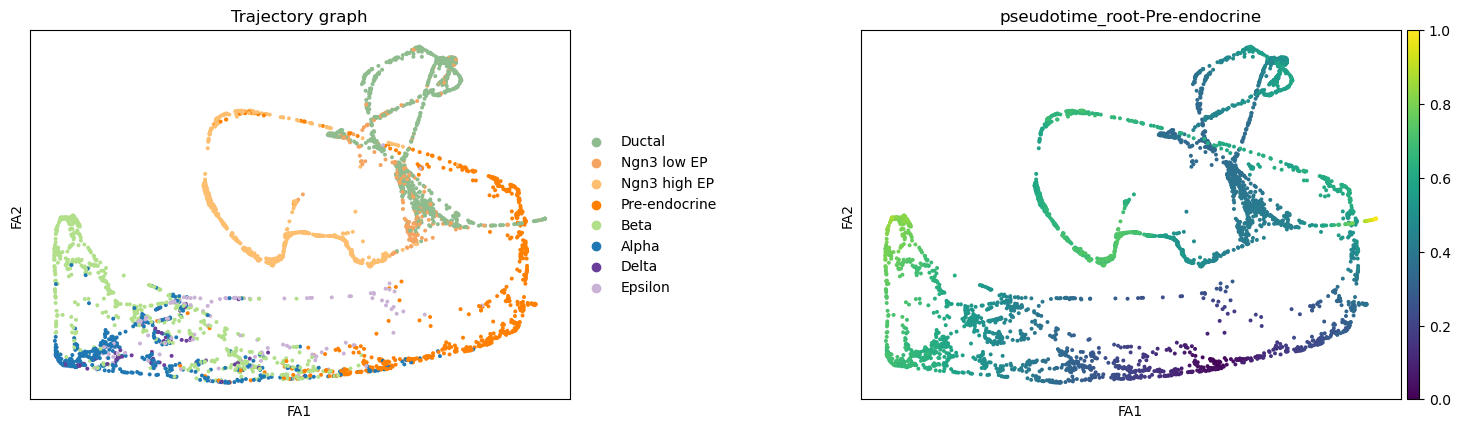

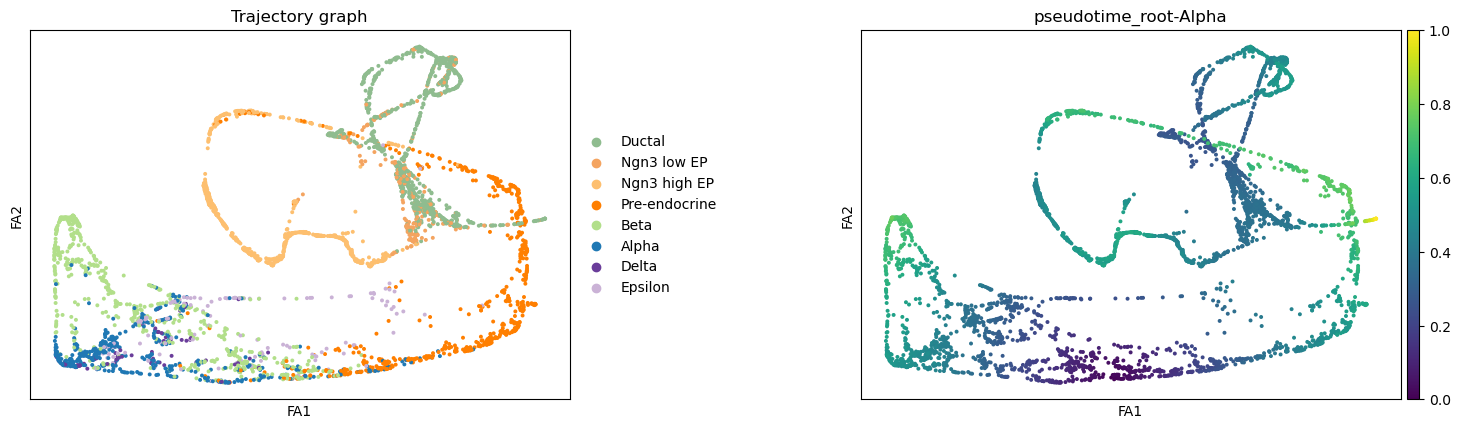

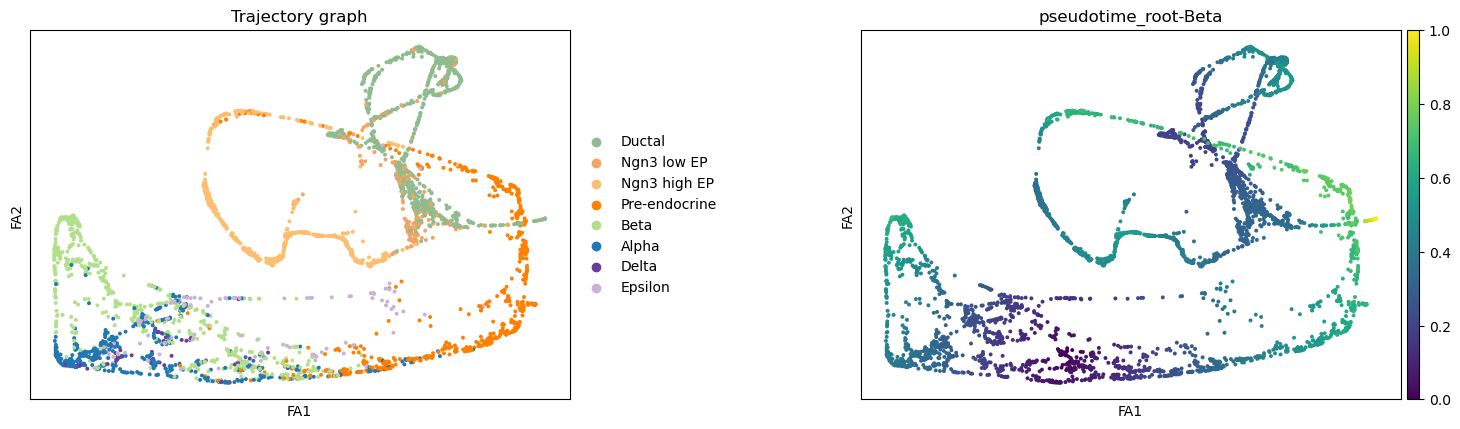

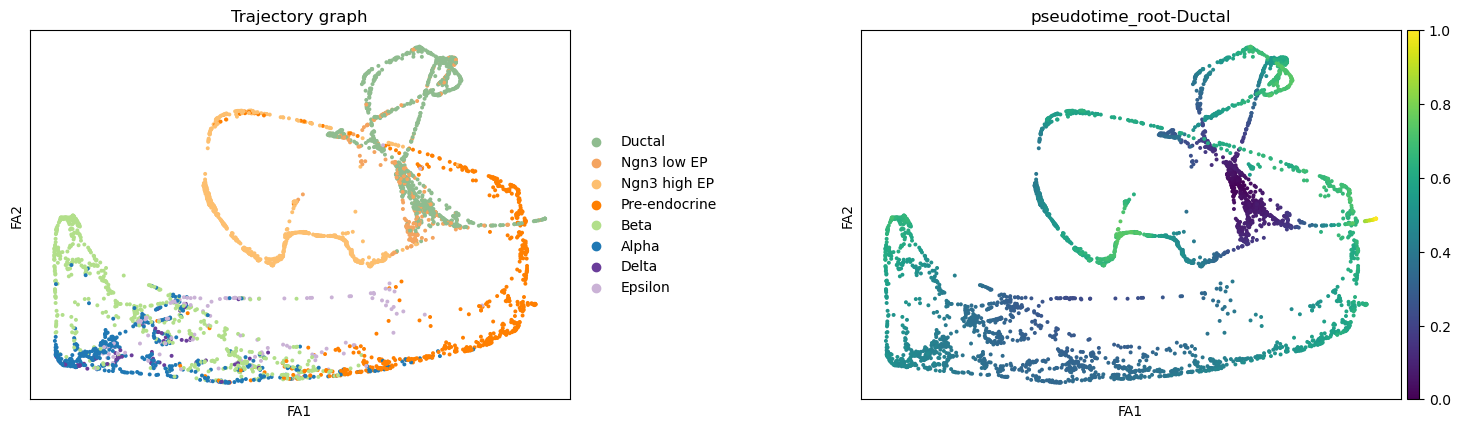

In [28]:
for cluster in list(set(adata_copy.obs[clustering])):
    sc.tl.diffmap(adata_copy, n_comps=10)
    adata_copy.uns['iroot']=np.flatnonzero(adata_copy.obs[clustering] == cluster)[0]
    sc.tl.dpt(adata_copy)
    sc.pl.draw_graph(adata_copy, color=[clustering, 'dpt_pseudotime'], title=["Trajectory graph", f"pseudotime_root-{cluster}"], legend_loc='right margin', wspace=0.4)
    adata_copy.obs.rename({"dpt_pseudotime": f"pseudotime_root-{cluster}"}, inplace=True, axis=1)

In [29]:
if goi:
    sc.pl.draw_graph(adata_copy, colo=goi, legend_loc='right margin')

## Velocity genes

In [30]:
scv.tl.rank_velocity_genes(adata, groupby=clustering, min_corr=.3)

ranking velocity genes


/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/scvelo/tools/utils.py:463: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:39) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [31]:
velocity_genes = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
velocity_genes.head()

Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine     Beta    Alpha    Delta  \
0     Etl4       Glis3        Pde1c        Baiap3     Pax6  Zcchc16  Zcchc16   
1   Notch2        Etl4        Ptprs           Pam     Nnat    Nell1     Ank2   
2  Gm20649     Gm20649         Pclo          Sdk1    Ptprt   Prune2    Ptprt   
3     Rps3     Slc28a3     Rap1gap2          Gnas    Unc5c    Ndst4     Gbf1   
4     Sox5         Frk        Ttyh2         Abcc8  Tmem108    Kctd8   Snap25   

  Epsilon  
0   Tmcc3  
1  Gpr179  
2  Sorcs1  
3   Unc79  
4    Heg1

#### Gene of interest

In [32]:
if goi:
    scv.pl.velocity(adata, goi, ncols=2, save="velocity_goi.pdf")

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_

saving figure to file ../figures/velocity/scvelo_marker_velocity_genes_Ductal.pdf


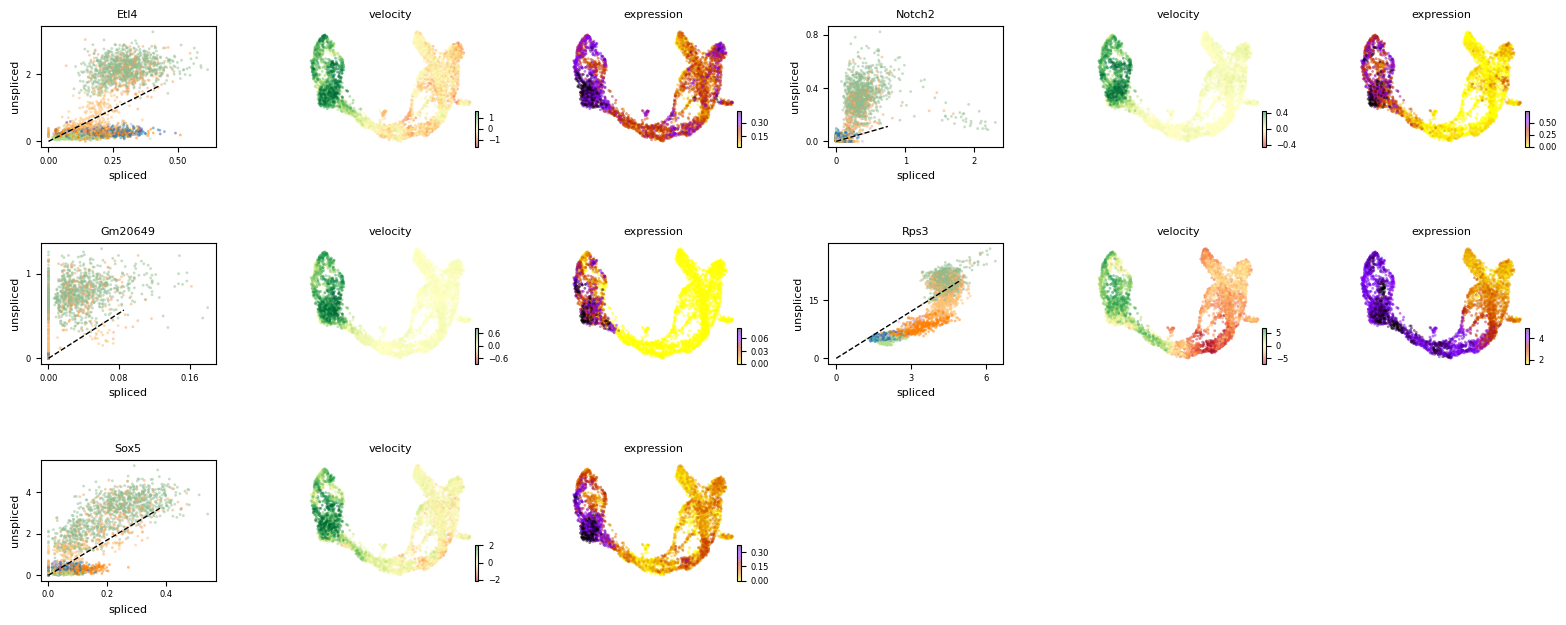

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_

saving figure to file ../figures/velocity/scvelo_marker_velocity_genes_Ngn3 low EP.pdf


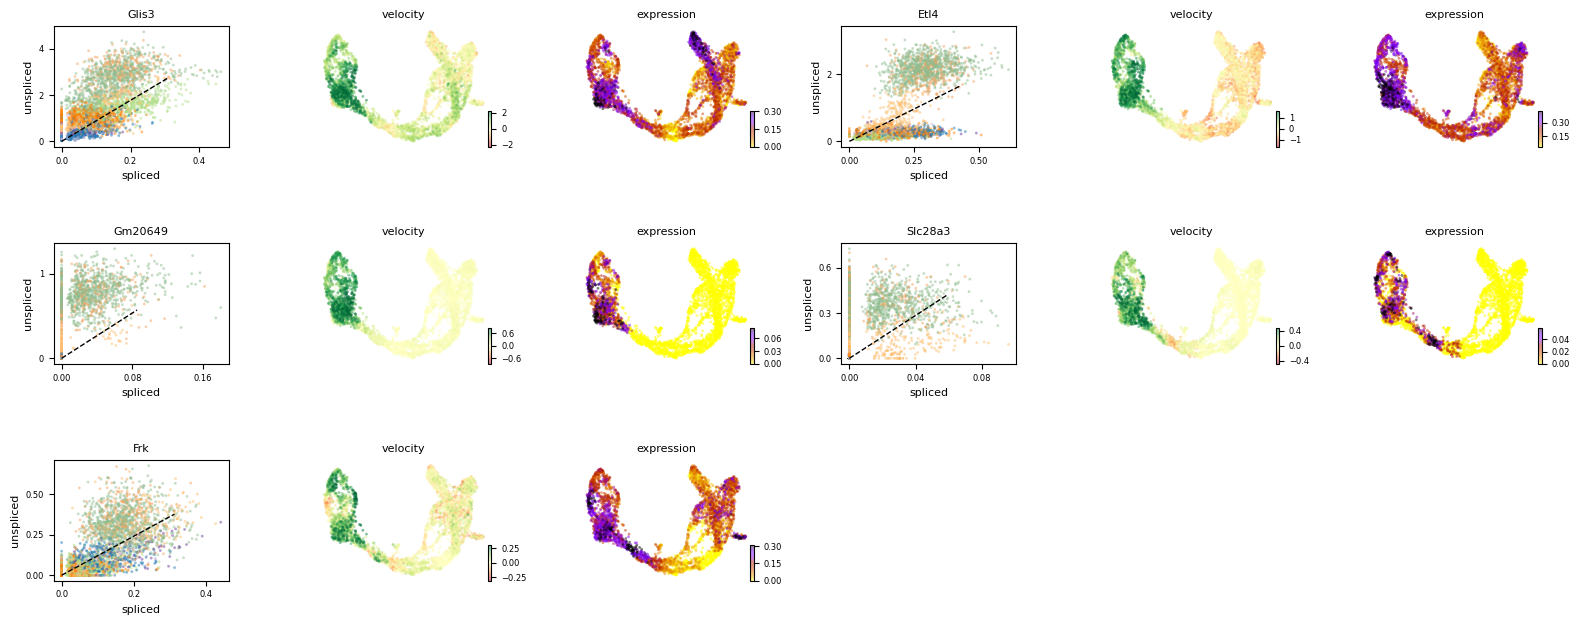

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_

saving figure to file ../figures/velocity/scvelo_marker_velocity_genes_Ngn3 high EP.pdf


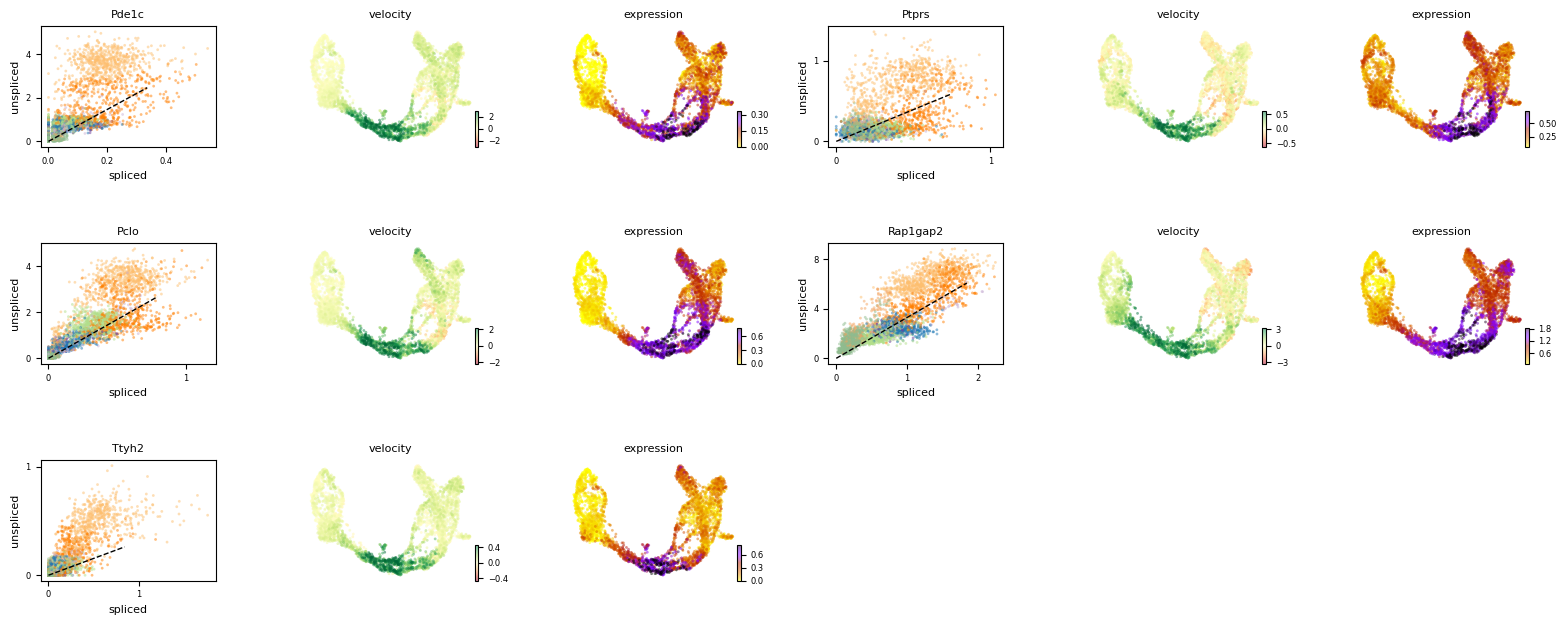

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_

saving figure to file ../figures/velocity/scvelo_marker_velocity_genes_Pre-endocrine.pdf


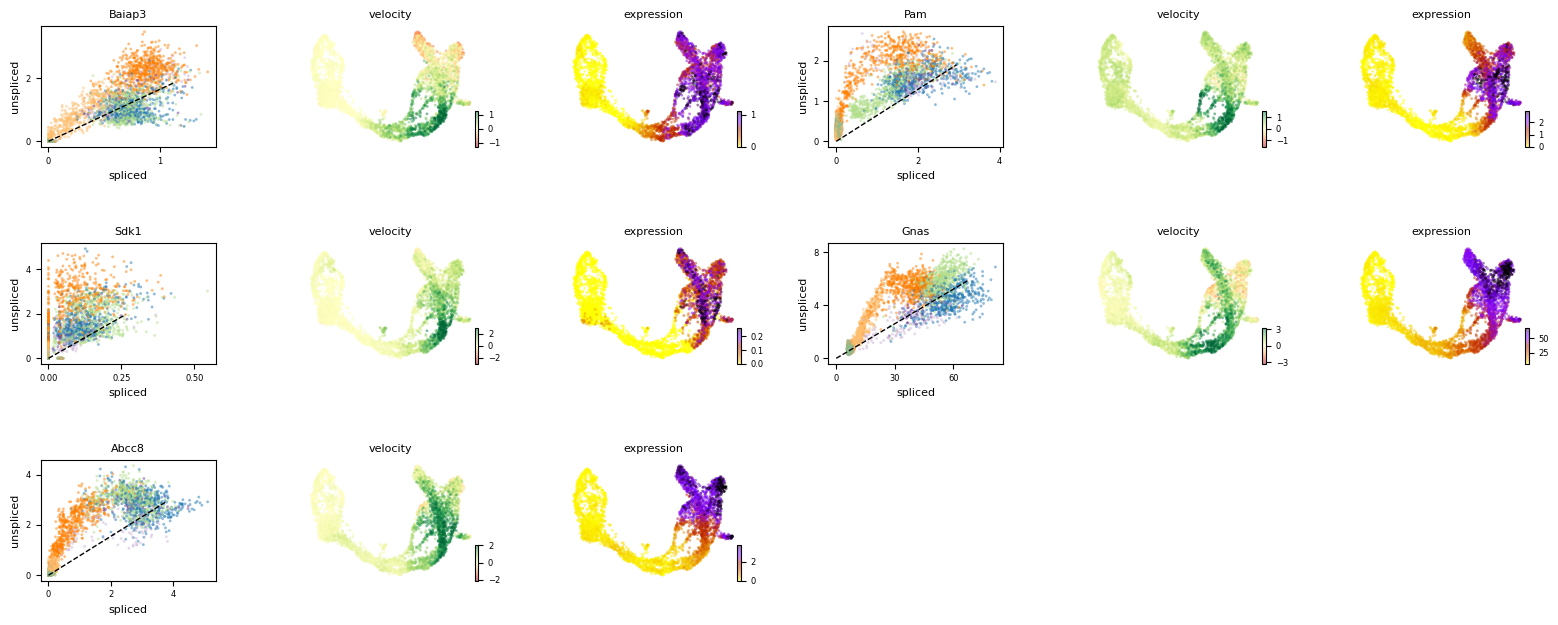

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_

saving figure to file ../figures/velocity/scvelo_marker_velocity_genes_Beta.pdf


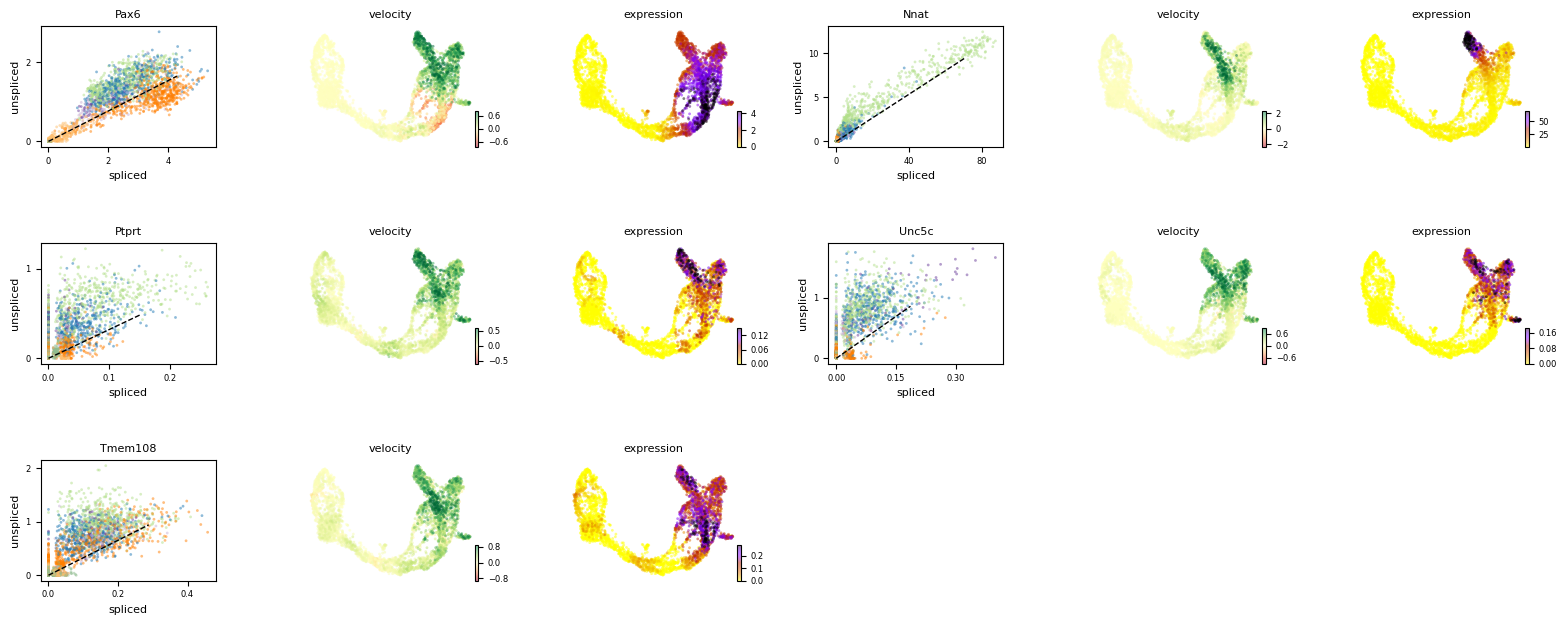

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_

saving figure to file ../figures/velocity/scvelo_marker_velocity_genes_Alpha.pdf


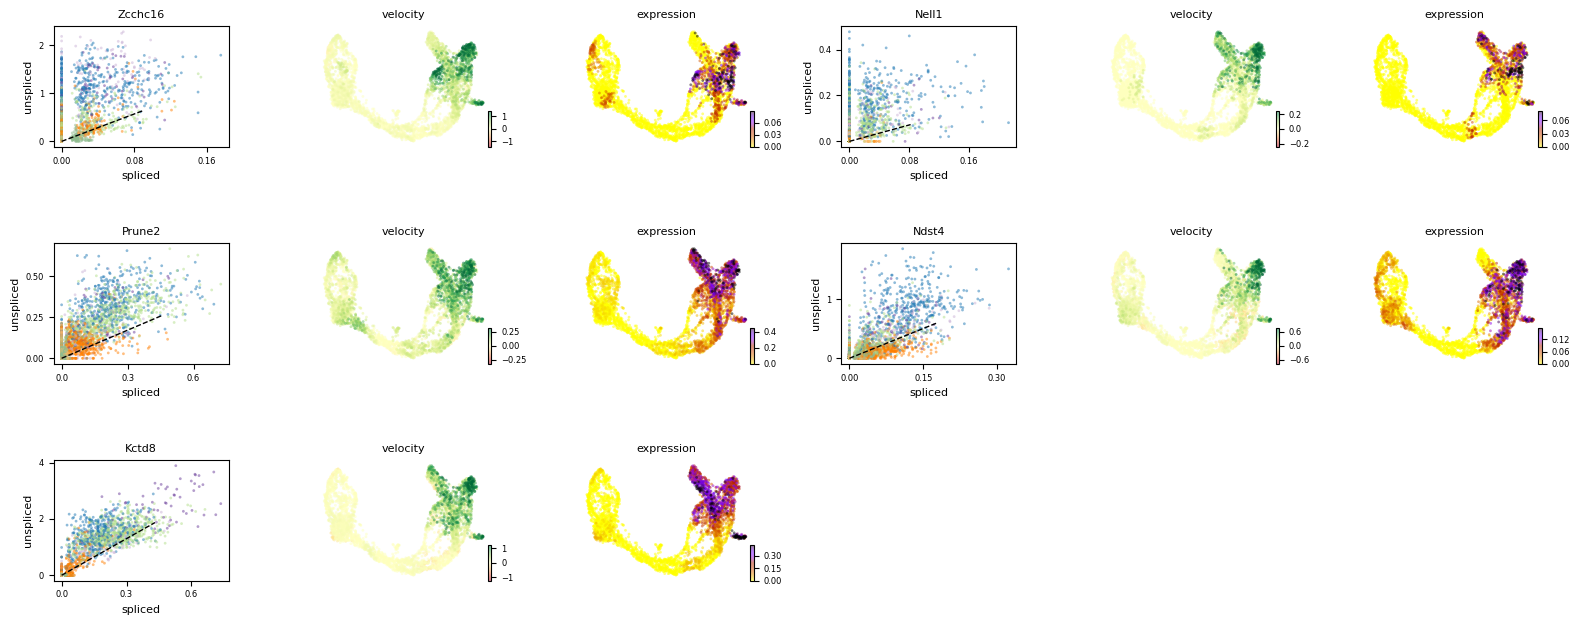

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_

saving figure to file ../figures/velocity/scvelo_marker_velocity_genes_Delta.pdf


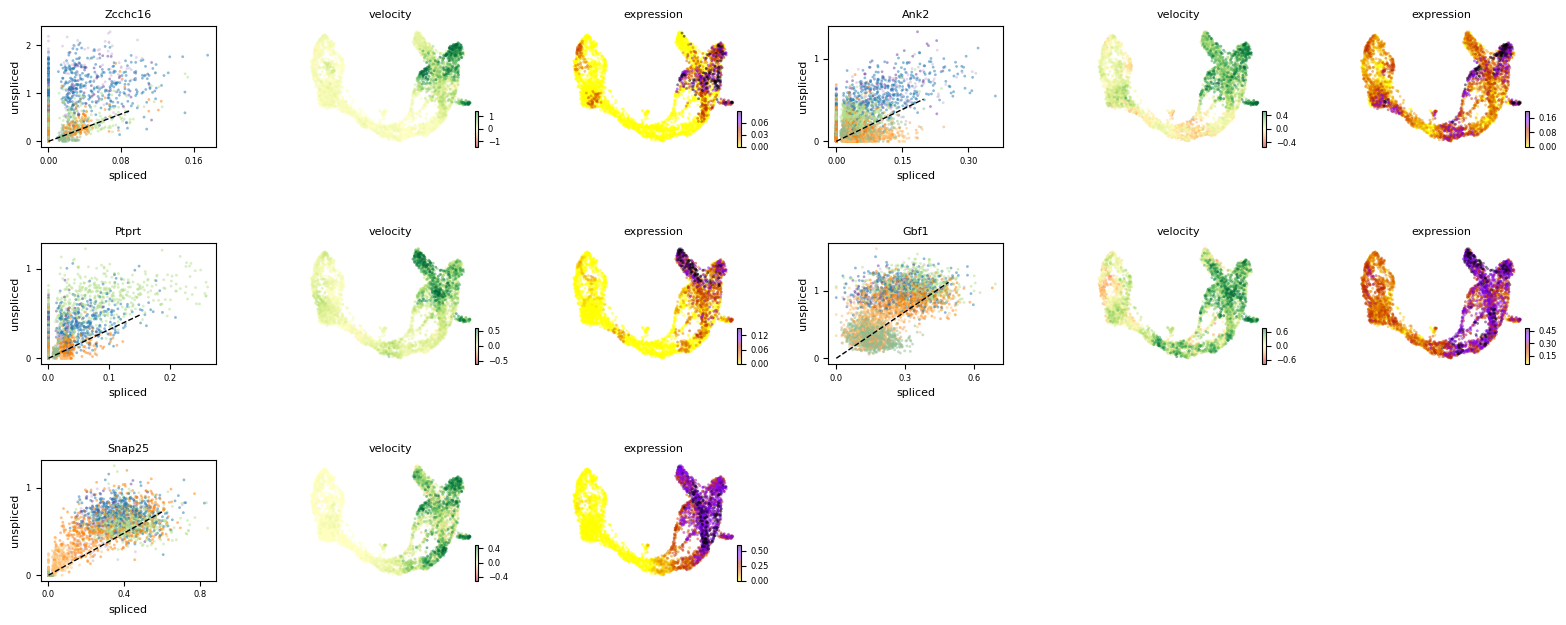

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_

saving figure to file ../figures/velocity/scvelo_marker_velocity_genes_Epsilon.pdf


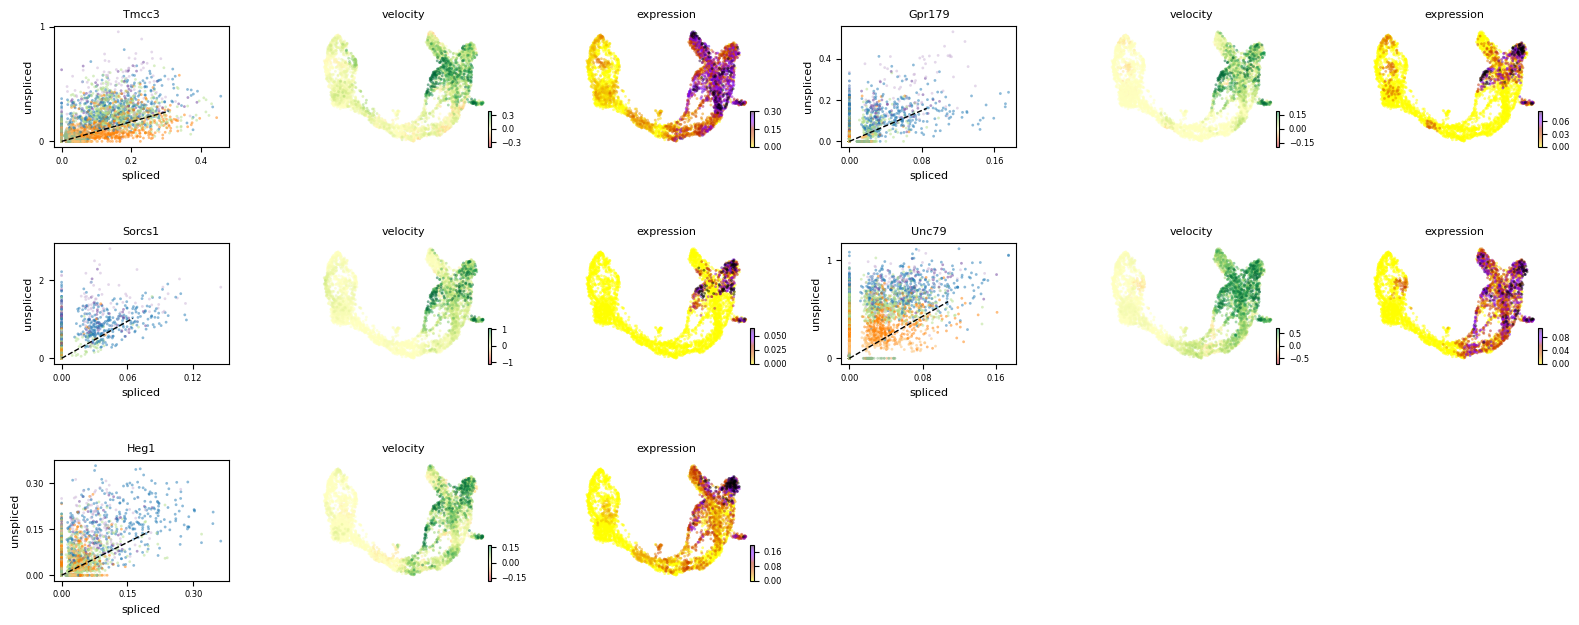

In [33]:
for col in velocity_genes.columns:
    genes = velocity_genes[col][:5]
    scv.pl.velocity(adata, genes, ncols=2, save=f"marker_velocity_genes_{col}.pdf")